# Primer modelo

Regresión lineal utilizando como predictores únicamente los datos propios del Índice IBEX 35. Este índice integra las cotizaciones de las 35 empresas más importantes de España. Es un índice ponderado según la capitalización bursatil de las 35 empresas que lo componen; es decir, las empresas que tienen una mayor capitalización tiene más peso en el índice.
El dataset con el que trabajaremos dispone de las siguientes variables:
- fecha, día de la muestra
- último, valor de cierre del índice expresado en puntos para ese día (unidad puntos)
- apertura, valor de apertura del índice expresado en puntos para ese día
- máximo, valor máximo alcanzado del índice expresado en puntos para ese día
- mínimo, valor mínimo alcanzado del índice expresado en puntos para ese día
- volumen, número de operaciones de compraventa cerradas para ese día (unidad millones)
- variación, variación del valor del índice con respecto al día anterior (unidad %)
- deuda_publica, conjunto de deudas que mantiene el Estado español frente a los particulares que pueden ser españoles o de otro país
- ipc, indicador que mide la variación de los precios de una cesta de bienes y servicios en un lugar concreto durante un determinado periodo de tiempo
- tasa_paro, mide el nivel de desocupación en relación con la población activa
- pib, suma de todos los bienes y servicios finales que produce un país o una economía, elaborados dentro del territorio nacional tanto por empresas nacionales como extranjeras, y que se registran en un periodo determinado

La variable a predecir:  
- el valor último o de cierre

En esta primera prueba vamos a utilizar el dataset completo con datos desde el 09-09-1991.

## Carga de las librerías y datos

In [17]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Cargamos los datos de entrada
data = pd.read_csv("./dataset/IBEX35/final_historic_data_with_metrics_IBEX35_all.csv")
data.shape

(7283, 11)

## Análisis exploratorio de los datos y relación entre variables

Visualizamos una pequeña muestra del dataset:

In [3]:
data.head(-10)

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
0,1991-09-09,"2.772,94","2.773,63","2.774,53","2.765,69",NaN,"-0,23%",NaN,NaN,NaN,NaN
1,1991-09-10,"2.756,07","2.764,26","2.764,26","2.750,66",NaN,"-0,61%",NaN,NaN,NaN,NaN
2,1991-09-11,"2.749,87","2.748,25","2.752,54","2.745,74",NaN,"-0,22%",NaN,NaN,NaN,NaN
3,1991-09-12,"2.763,62","2.749,43","2.766,34","2.749,43",NaN,"0,50%",NaN,NaN,NaN,NaN
4,1991-09-13,"2.772,87","2.769,13","2.781,56","2.765,43",NaN,"0,33%",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7268,2020-06-22,"7.345,70","7.371,60","7.426,90","7.300,70","220,42M","-0,92%",NaN,NaN,"14,81",NaN
7269,2020-06-23,"7.438,40","7.408,80","7.495,10","7.366,60","260,90M","1,26%",NaN,NaN,"14,81",NaN
7270,2020-06-24,"7.195,50","7.403,90","7.440,90","7.195,50","248,46M","-3,27%",NaN,NaN,"14,81",NaN
7271,2020-06-25,"7.270,30","7.176,40","7.295,80","7.077,80","267,87M","1,04%",NaN,NaN,"14,81",NaN


Vemos los tipos de las columnas para ver si sería conveniente realizar algún tipo de transformación:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7283 entries, 0 to 7282
Data columns (total 11 columns):
fecha            7283 non-null object
ultimo           7283 non-null object
apertura         7283 non-null object
maximo           7283 non-null object
minimo           7283 non-null object
vol              3951 non-null object
variacion        7283 non-null object
deuda_publica    4082 non-null object
ipc              4435 non-null object
tasa_paro        4644 non-null object
pib              6325 non-null object
dtypes: object(11)
memory usage: 626.0+ KB


Y obtenemos algunos estadísticos:

In [5]:
data.describe()

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
count,7283,7283,7283,7283,7283,3951,7283,4082,4435,4644,6325
unique,7283,6992,7045,7011,7006,3716,823,192,175,73,74
top,2011-07-22,"8.550,00","10.349,60","8.447,80","9.543,80","238,02M","0,11%","703.925,92","3,51","11,23","0,96"
freq,1,3,3,3,3,3,42,23,64,66,194


Una vez analizada la información vemos que si sería conveniente realizar una serie de transformaciones en los datos:
- Cambiar el formato de miles y decimales de todas las columnas
- En el campo volumen existen dos tipos de unidades (M millones) y (B billones)
    + (M millones) vamos a quitar la unidad y no haremos la transformación en los datos
    + (B billones) vamos a quitar la unidad y multiplicamos por 1000
- En el campo variación se va a quitar el %
- Quitaremos la columna fecha
- Rellenamos los valores nulos utilizando el método "forward fill" de forma que los valores no nulos se copien hacia adelante siempre que se encuentren valores nulos
- Convertir los NaN a 0
- Convertir las columnas a float

In [6]:
# Vamos a aplicar una serie de transformaciones a los datos
# Cambiamos el formato de miles y decimales de todas las columnas
data = data.replace(r'[.]','', regex=True)
data = data.replace(r'[,]','.', regex=True)
# Volumen: existen dos tipos de unidades (M millones) y (B billones)
# Se harán dos transformaciones:
# - (M millones) vamos a quitar la unidad y no haremos la transformación en los datos
# - (B billones) vamos a quitar la unidad y multiplicamos por 1000
transform = {'B': 10**3, 'M': 1}
def convert_cash(item):
    try:
        item_transform = item[-1]
        return float(item[:-1]) * transform[item_transform]
    except TypeError:
        return item
data['vol'] = data['vol'].map(lambda x: convert_cash(x) if (pd.notnull(x)) else x)   
# Variación: vamos a quitar el % aunque no haremos la transformación en los datos 
data['variacion'] = data['variacion'].map(lambda x: x.rstrip('%') if (pd.notnull(x)) else x)
# Quitamos la columna fecha
data = data.drop(['fecha'], axis=1)
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos en las columnas: deuda_publica, ipc, tasa_paro y pib
data['deuda_publica'].fillna(method='ffill', inplace=True)
data['ipc'].fillna(method='ffill', inplace=True)
data['tasa_paro'].fillna(method='ffill', inplace=True)
data['pib'].fillna(method='ffill', inplace=True)
# Convertimos los NaN a 0
data = data.fillna(0)
# Convertimos las columnas a float
data = data.astype({"ultimo": float, "apertura": float, "maximo": float, "minimo": float, "vol": float, 
                    "variacion": float, "deuda_publica": float, "ipc": float, "tasa_paro": float, "pib": float})
data

,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
0,2772.94,2773.63,2774.53,2765.69,0.00,-0.23,0.00,0.00,0.00,0.00
1,2756.07,2764.26,2764.26,2750.66,0.00,-0.61,0.00,0.00,0.00,0.00
2,2749.87,2748.25,2752.54,2745.74,0.00,-0.22,0.00,0.00,0.00,0.00
3,2763.62,2749.43,2766.34,2749.43,0.00,0.50,0.00,0.00,0.00,0.00
4,2772.87,2769.13,2781.56,2765.43,0.00,0.33,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
7278,7556.20,7566.50,7632.30,7517.30,253.51,2.06,1234693.96,-0.92,14.81,-5.21
7279,7447.40,7491.50,7511.30,7441.30,191.35,-1.44,1234693.96,-0.92,14.81,-5.21
7280,7326.40,7361.00,7382.70,7307.40,213.49,-1.62,1234693.96,-0.92,14.81,-5.21
7281,7236.90,7369.90,7383.50,7221.10,176.47,-1.22,1234693.96,-0.92,14.81,-5.21


In [7]:
data.describe()

,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
count,7283.000000,7283.000000,7283.000000,7283.000000,7283.000000,7283.000000,7.283000e+03,7283.000000,7283.000000,7283.000000
mean,8429.558118,8431.579102,8494.979319,8358.127880,91.093691,0.023091,4.438976e+05,1.110662,10.444862,0.361131
std,3073.212973,3075.515732,3095.488550,3050.156067,120.535669,1.415710,4.557990e+05,1.533976,9.112491,0.982221
min,1873.580000,1891.920000,1922.340000,1861.900000,0.000000,-14.060000,0.000000e+00,-1.370000,0.000000,-5.210000
25%,6783.080000,6799.400000,6860.300000,6707.670000,0.000000,-0.680000,0.000000e+00,0.000000,0.000000,0.000000
50%,9052.000000,9058.600000,9118.800000,8970.300000,21.620000,0.060000,3.810523e+05,0.020000,10.740000,0.590000
75%,10370.400000,10381.250000,10454.850000,10301.950000,175.925000,0.750000,9.616952e+05,2.380000,18.660000,0.940000
max,15945.700000,15999.200000,16040.400000,15868.600000,1080.000000,14.430000,1.234694e+06,5.270000,26.940000,1.620000


In [ ]:
# Guardamos el dataset transformado en csv para hacer unas pruebas en R
# data.to_csv ("./dataset/IBEX35/final_historic_data_IBEX35_with_metrics_toR.csv", index = False, header=True)

A continuación vamos a visualizar una serie de gráficas por cada variable de entrada para visualizar entre qué valores se concentran la mayoría de los registros

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


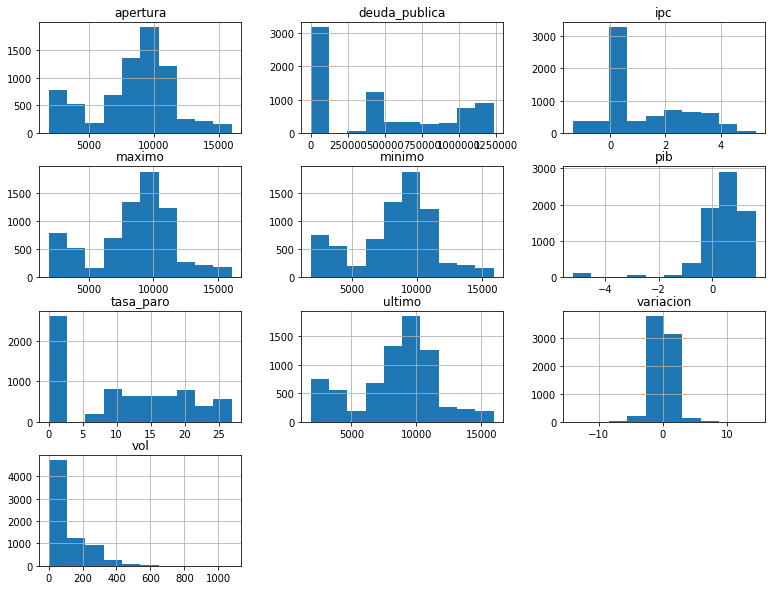

In [8]:
#data.hist(ax=ax)
#plt.show()
fig, ax = plt.subplots(figsize=(13,10))
data.hist(ax=ax)
plt.show()

Realizamos un diagrama de dispersión para analizar los datos con respecto a las variables, ver la distribución de los mismos y analizar de forma rápida si contiene outliers:

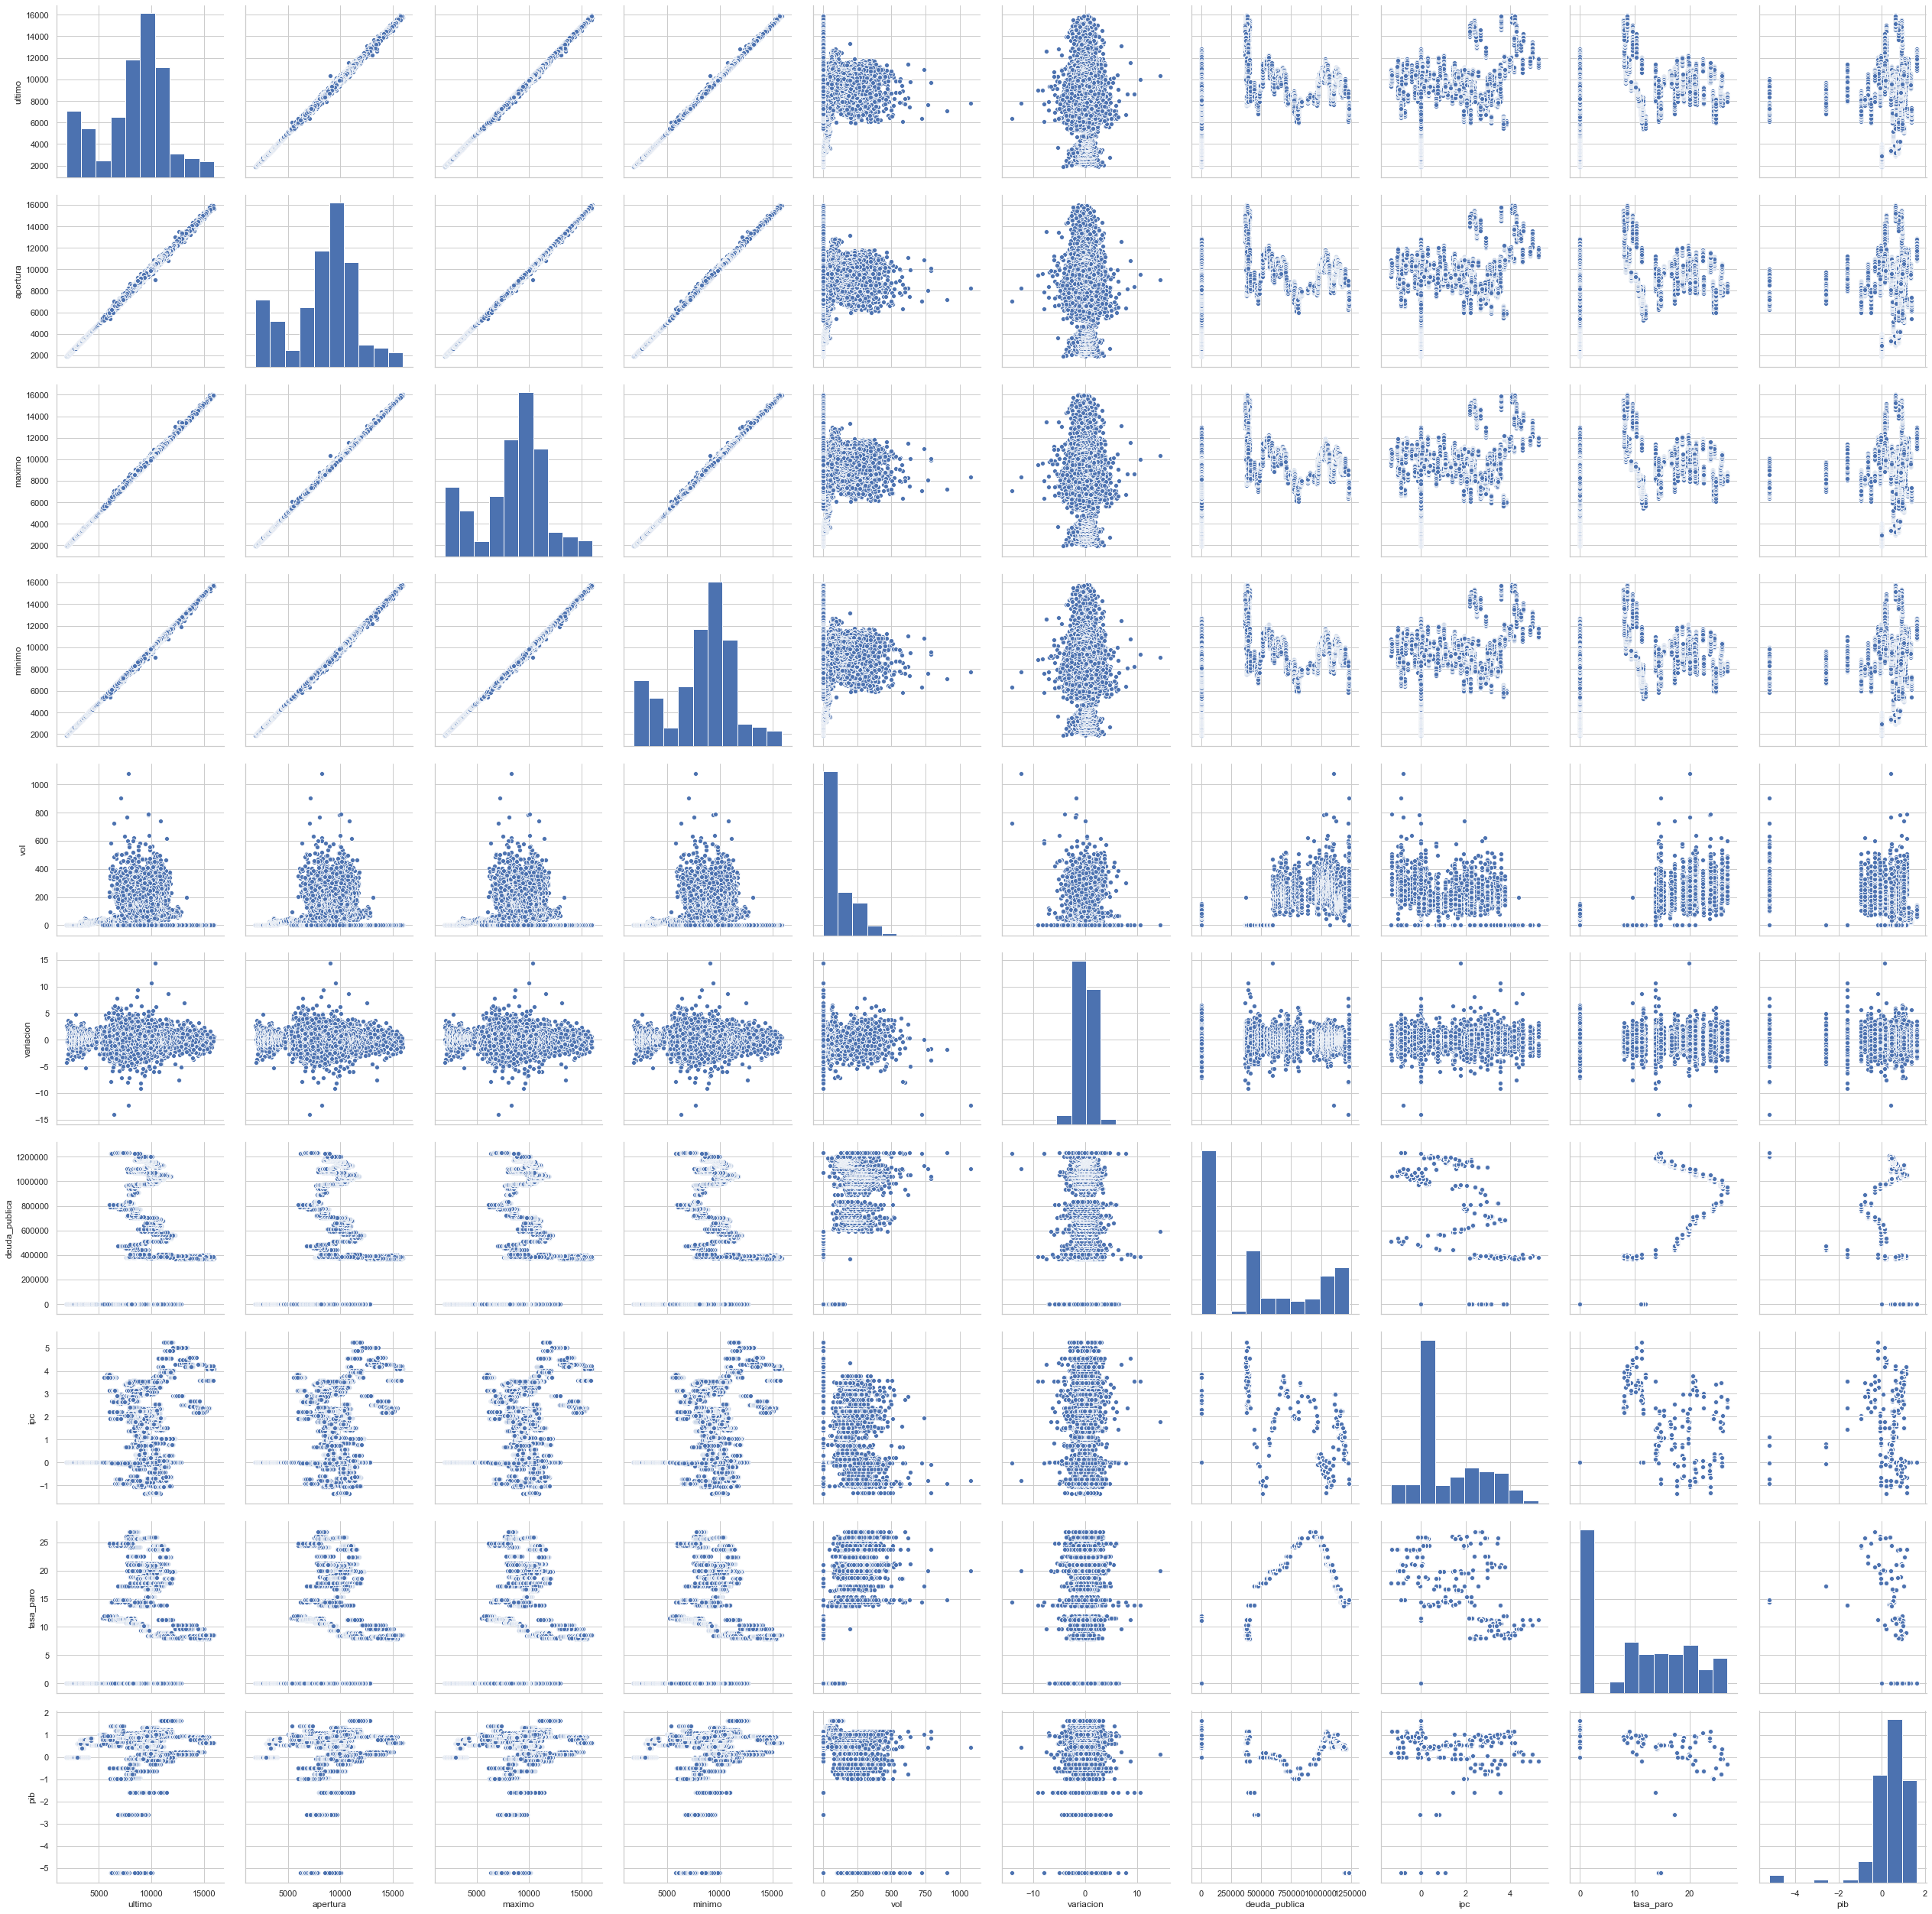

In [9]:
# Scatterplot matrix para mostrar la distribución de los datos
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
sns.pairplot(data, height=3.5)
plt.show()

Y pintamos la matriz de correlación:

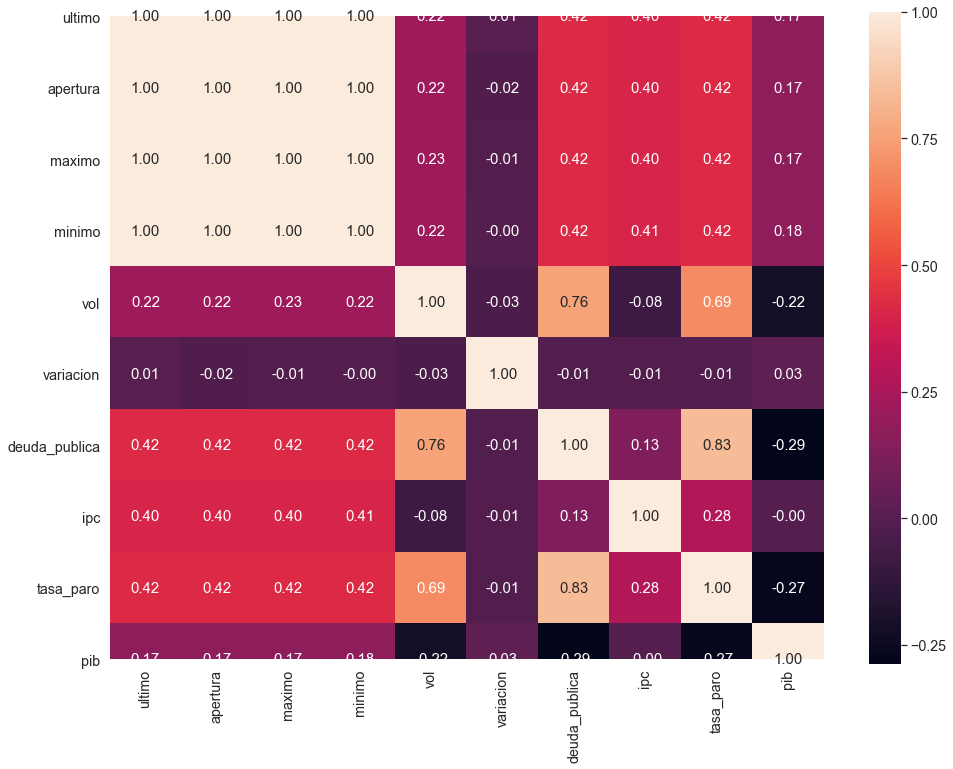

In [10]:
# Mostramos el diagrama de correlación entre los distintos predictores utilizando Seaborn > heatmap
corr_data = np.corrcoef(data.values.T)
sns.set(font_scale=1.3)
plt.subplots(figsize=(16,12))
heatmap_data = sns.heatmap(corr_data,
                          cbar=True,
                          annot=True,
                          square=True,
                          fmt='.2f',
                          annot_kws={'size':15},
                          yticklabels=["ultimo","apertura","maximo","minimo","vol","variacion","deuda_publica","ipc","tasa_paro","pib"],
                          xticklabels=["ultimo","apertura","maximo","minimo","vol","variacion","deuda_publica","ipc","tasa_paro","pib"])
plt.show()

Esta información es crítica a la hora de identificar cuáles pueden ser los mejores predictores para el modelo, qué variables presentan relaciones de tipo no lineal y para identificar colinialidad entre predictores.
De este análisis se pueden extraer las siguientes conclusiones:
- Las variables que tienen una mayor relación lineal con ultimo son: apertura (r=1.00), maximo (r=1.00) y minimo (r=1.00)
- Los predictores apertura, maximo y minimo estan altamente correlacionados (r>=0.99) por lo que no se van a utilizar
- La variable variación como depende directamente de la variable a predecir tampoco se va a incorporar
- las variables que presenta bastante relación lineal con ultimo son: deuda_publica (r=0.42), ipc (r=0.40), tasa_paro (r=0.42) y en menor medida pib (r=0.17)

## Selección de los predictores y ajuste de un modelo lineal múltiple

Creamos trainig y test, 80% y 20% del dataset

In [11]:
# Definimos las variables de entrada y salida
X = data[["deuda_publica","ipc", "tasa_paro", "pib"]]
y = data.ultimo
# Creamos los datasets de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (5826, 4) (5826,)
Testing dataset shape: (1457, 4) (1457,)


Para la selección de los predictores vamos a utilizar la técnica "Best Subset Selection" que consiste en evaluar todos los posibles modelos que se pueden crear por combinación de los predictores disponibles.

In [12]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = metrics.mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    MSE = metrics.mean_squared_error(Y,model_k.predict(X))
    return RSS, R_squared, MSE

#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
Y = y_train
X = X_train
k = 11
RSS_list, R_squared_list, MSE_list, feature_list = [],[],[],[]
numb_features = []

for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
    #Looping over all possible combinations
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        MSE_list.append(tmp_result[2])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list,'R_squared':R_squared_list,'MSE':MSE_list,'features':feature_list})
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


,numb_features,RSS,R_squared,MSE,features
0,1,4.491434e+10,0.179878,7.709293e+06,"(deuda_publica,)"
1,1,4.620312e+10,0.156346,7.930505e+06,"(ipc,)"
2,1,4.496059e+10,0.179034,7.717231e+06,"(tasa_paro,)"
3,1,5.310472e+10,0.030325,9.115125e+06,"(pib,)"
4,2,3.840627e+10,0.298714,6.592219e+06,"(deuda_publica, ipc)"
5,2,4.405215e+10,0.195622,7.561304e+06,"(deuda_publica, tasa_paro)"
6,2,3.967180e+10,0.275606,6.809440e+06,"(deuda_publica, pib)"
7,2,4.032251e+10,0.263724,6.921132e+06,"(ipc, tasa_paro)"
8,2,4.455709e+10,0.186402,7.647973e+06,"(ipc, pib)"
9,2,4.003629e+10,0.268950,6.872002e+06,"(tasa_paro, pib)"


In [13]:
df_min_rss = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max_r_squared = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
df_min_mse = df[df.groupby('numb_features')['MSE'].transform(min) == df['MSE']]

print("Features by min RSS:")
display(df_min_rss)
print("Features by min RMSE:")
display(df_max_r_squared.head(3))
print("Features by min MSE:")
display(df_min_mse.head(3))

Features by min RSS:


,numb_features,RSS,R_squared,MSE,features
0,1,4.491434e+10,0.179878,7.709293e+06,"(deuda_publica,)"
4,2,3.840627e+10,0.298714,6.592219e+06,"(deuda_publica, ipc)"
11,3,3.361563e+10,0.386189,5.769934e+06,"(deuda_publica, ipc, pib)"
14,4,3.351684e+10,0.387993,5.752976e+06,"(deuda_publica, ipc, tasa_paro, pib)"


Features by min RMSE:


,numb_features,RSS,R_squared,MSE,features
0,1,4.491434e+10,0.179878,7.709293e+06,"(deuda_publica,)"
4,2,3.840627e+10,0.298714,6.592219e+06,"(deuda_publica, ipc)"
11,3,3.361563e+10,0.386189,5.769934e+06,"(deuda_publica, ipc, pib)"


Features by min MSE:


,numb_features,RSS,R_squared,MSE,features
0,1,4.491434e+10,0.179878,7.709293e+06,"(deuda_publica,)"
4,2,3.840627e+10,0.298714,6.592219e+06,"(deuda_publica, ipc)"
11,3,3.361563e+10,0.386189,5.769934e+06,"(deuda_publica, ipc, pib)"


Ahora vamos a evaluar distintos estadísticos para ver cuál es el mejor modelo:
- RSS: Residual sum of squares for each model. RSS siempre disminuye conforme más predictores se incluyan en el modelo.
- Adj.R2: Adjusted r-squared, se corresponde al cuadrado de la correlación entre la variable respuesta y el modelo lineal ajustado. En este caso cuanto mayor es el R2 ajustado menor su test error. Una vez las variables más importantes han sido incluidas en el modelo, la adición de variables adicionales con poca relación con la variable respuesta solo añadirá ruido y una pequeña reducción en el RSS; es decir, penaliza la inclusión de variables innecesarias.
- MSE: Test mean squared error, que equivale al test Residual Sum of Squares dividido entre el número de observaciones.

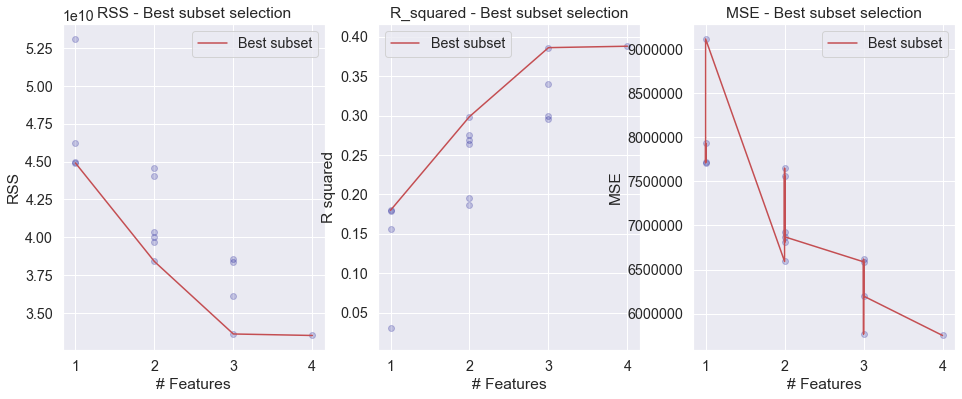

In [14]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df['min_MSE'] = df.groupby('numb_features')['MSE'].transform(min)
df.head()

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 3, 3)
ax.scatter(df.numb_features,df.MSE, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.MSE,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('MSE')
ax.set_title('MSE - Best subset selection')
ax.legend()

plt.show()

Por el criterio "del codo" tomando como base el estadístico MSE tiene sentido tomar 3 variables.

En una primera prueba se van a considerar todas las variables ya que minizan el MSE. Se va a implementar el modelo utilizando sklearn:

In [15]:
# Definimos el algoritmo a utilizar
model01_lr_multiple = linear_model.LinearRegression()
model01_lr_multiple.fit(X_train, y_train)

# Obtenemos el valor de las pendientes o coeficientes de los predictores
print("Valor de las pendientes de los predictores: ", model01_lr_multiple.coef_)
# Valor de la intersección
print("Valor de la intersección: ", model01_lr_multiple.intercept_)

Valor de las pendientes de los predictores:  [2.72139501e-03 6.45767621e+02 2.72366147e+01 9.67752778e+02]
Valor de la intersección:  5864.062558261796


Según observamos en los resultados el coeficiente obtenido para deuda_publica, ipc, tasa_paro y pib son estadísticamente significativos por lo que podemos establecer que existe relación entre los predictores y la respuesta.

El valor Multiple R-squared (R2) indica que el modelo calculado explica el 38% de la variablidad presente en la variable respuesta (ultimo) a su promedio es explicado por el modelo de regresión ajustado. Podemos concluir que el modelo lineal es adecuado para describir la relación que existe entre esas variables independientes (deuda_publica, ipc, tasa_paro y pib). 

El modelo que se obtiene es:

ultimo = 5864.062558261796 + 2.72139501e-03 * deuda_publica + 6.45767621e+02 * ipc + 2.72366147e+01 * tasa_paro + 9.67752778e+02 * pib

Aplicamos la técnica de Cross Validation sobre los datos de train.

In [30]:
# Cross validation
from sklearn.model_selection import cross_val_score

# Cross Validation
scores = cross_val_score(model01_lr_multiple,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

print("Métricas cros_validation:", scores)
print("Train > MSE cross_validation: ", scores.mean())

Métricas cros_validation: [-5769488.74780764 -6012007.00406764 -5483584.9091501  -5625364.45966655
 -5949194.0251468 ]
Train > MSE cross_validation:  -5767927.829167747


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [18]:
path_model_save = "./models/lm_fit_ultimo_all_data_deuda_publica+ipc+tasa_paro+pib_python.pkl"  
joblib.dump(model01_lr_multiple, path_model_save)

['./models/lm_fit_ultimo_all_data_deuda_publica+ipc+tasa_paro+pib_python.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [19]:
model01_lr_multiple = joblib.load(path_model_save)

Finalmente realizamos las prediciones sobre los datos de test y obtenemos distintos estadísticos para comprobar como de eficiente es nuestro modelo.

In [20]:
y_pred = model01_lr_multiple.predict(X_test)

In [21]:
# MAE: Mean absolute error
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
# MSE: Mean squared error
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))
# RMSE: Root mean squared error
print("Root mean squared error: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# Coeficiente de variación. El mejor puntaje es un 1.0
print("R-Cuadrado: %.2f" % metrics.r2_score(y_test, y_pred))
# Precisión del modelo
print("Precisión del modelo: ", model01_lr_multiple.score(X_test, y_pred))

Mean absolute error: 2029.14
Mean squared error: 5868972.49
Root mean squared error: 2422.60
R-Cuadrado: 0.39
Precisión del modelo:  1.0


El valor Multiple R-squared (R2) indica que el modelo calculado explica el 39% de la variablidad presente en la variable respuesta (ultimo) a su promedio es explicado por el modelo de regresión ajustado. Podemos concluir que el modelo lineal es adecuado para describir la relación que existe entre esas variables independientes (deuda_publica, ipc, tasa_paro y pib). 

Vamos a plotear los valores predichos por el modelo.

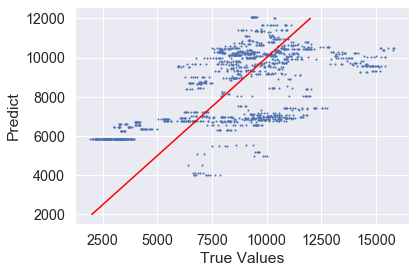

In [22]:
# Ploteamos los valores reales frente a los predichos por el modelo
x = np.linspace(2000, 12000, 100)
y = x
plt.plot(x, y, color='red')
plt.scatter(y_test, y_pred, s=1)
plt.xlabel("True Values")
plt.ylabel("Predict")
plt.show()

A continuación vamos a mostrar los valores reales frente a los predichos por el modelo:

In [23]:
test_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
test_vs_pred

,Actual,Predicted
2043,10613.60,6967.300726
1055,3543.54,6599.554670
489,3250.89,5864.062558
369,2618.47,5864.062558
1080,3651.31,6435.036698
...,...,...
577,3654.49,5864.062558
6254,8163.30,9309.316064
3481,10132.90,10156.141367
4957,10168.10,10114.239356


Para comparar la variación entre ambos valores de una forma más rápida y visual vamos a plotear los valores:

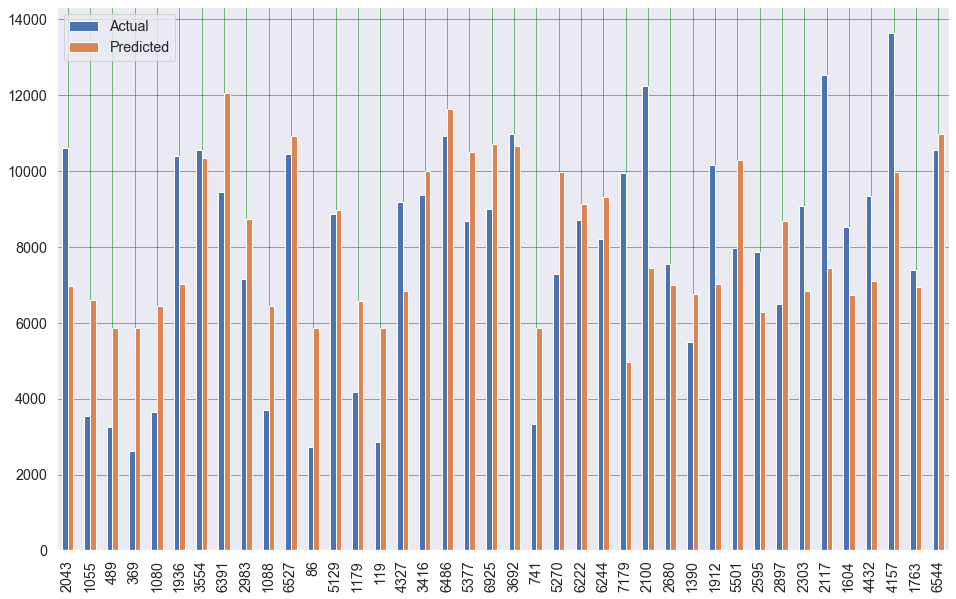

In [24]:
df1 = test_vs_pred.head(40)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Como podemos observar el modelo es bastante impreciso.

### Análisis de los residuos
Añadimos la columna Residuals para poder realizar una serie de comprobaciones en los residuos.

In [25]:
test_vs_pred["Residuals"] = y_test-y_pred
test_vs_pred

,Actual,Predicted,Residuals
2043,10613.60,6967.300726,3646.299274
1055,3543.54,6599.554670,-3056.014670
489,3250.89,5864.062558,-2613.172558
369,2618.47,5864.062558,-3245.592558
1080,3651.31,6435.036698,-2783.726698
...,...,...,...
577,3654.49,5864.062558,-2209.572558
6254,8163.30,9309.316064,-1146.016064
3481,10132.90,10156.141367,-23.241367
4957,10168.10,10114.239356,53.860644


Ploteamos el gráfico de Residuos vs. Valores predichos por el modelo; aquí podemos observar:
- No encontramos sesgos o tendencias en los residuos
- La varianza no es constante, existe una dispersión irregular
- No observamos outliers

Los residuos se distribuyen de forma aleatoria entorno a 0 por lo que se acepta la linealidad.
El error tiene una relación lineal con la variable objetivo, sería mejorable quizá incorporando nuevos predictores. El rango de valores que toman los residuos es amplio, respecto a su valor medio de cero.

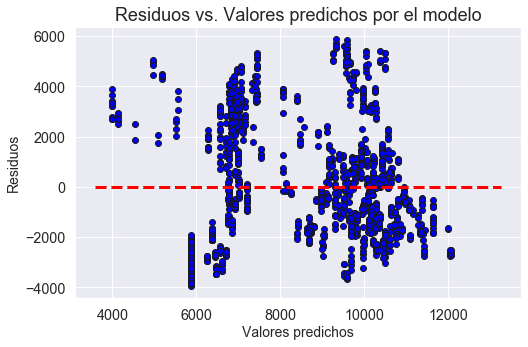

In [26]:
plt.figure(figsize=(8,5))
plt.title("Residuos vs. Valores predichos por el modelo",fontsize=18)
plt.scatter(x=y_pred,y=test_vs_pred["Residuals"],color='blue',edgecolor='k')
plt.grid(True)
xmin=min(y_pred)
xmax = max(y_pred)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Valores predichos",fontsize=14)
plt.ylabel("Residuos",fontsize=14)
plt.show()

Ploteamos los gráficos de Residuos vs. Variables explicativas - Nos va a permitir diagnosticar no linealidad y varianza no constante en los residuos. Al evaluar cada una de las variables de forma independiente nos permitirá ver rápidamente si es necesario transformar el modelo en caso de que dependa de una variable en particular.

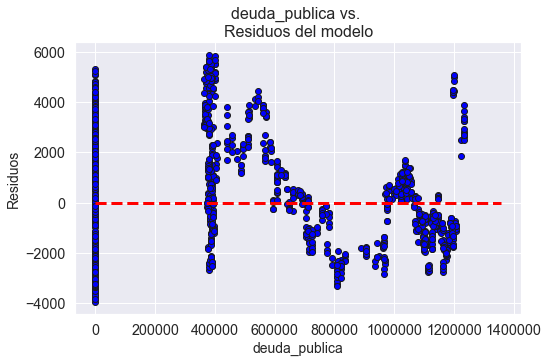

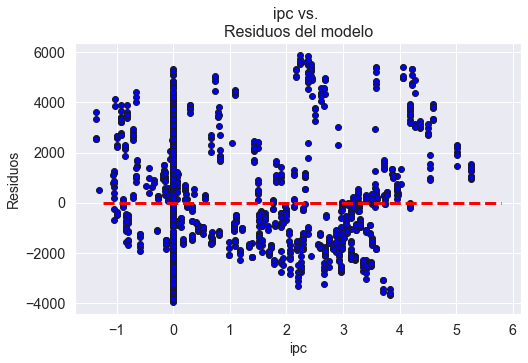

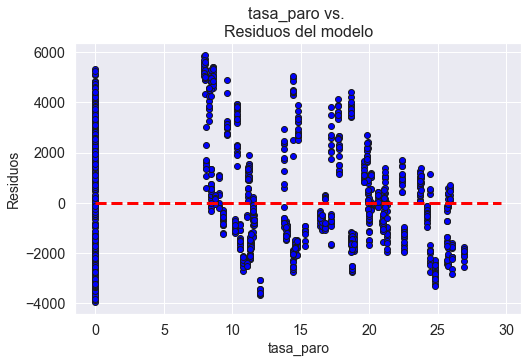

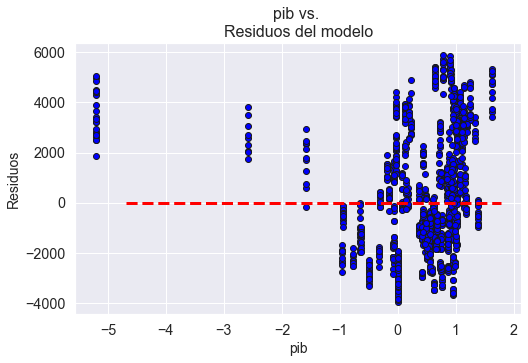

In [27]:
for c in X_test.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nResiduos del modelo".format(c),fontsize=16)
    plt.scatter(x=X_test[c],y=test_vs_pred["Residuals"],color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(X_test[c])
    xmax = max(X_test[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuos',fontsize=14)
    plt.show()

Ploteamos el Histograma de los residuos

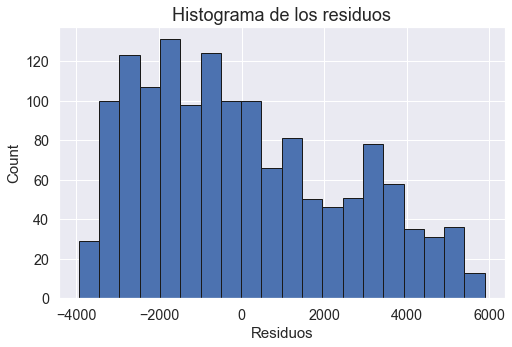

In [28]:
plt.figure(figsize=(8,5))
plt.hist(test_vs_pred["Residuals"],bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Residuos',fontsize=15)
plt.title("Histograma de los residuos",fontsize=18)
plt.show()

Ploteamos el Gráfico Q-Q normal - Compara los residuos estandarizados con la distribución teórica Normal. Si los puntos se alejan de la linea normal, indica que los residuos no se ajustan a una distribución Normal.

<Figure size 576x360 with 0 Axes>

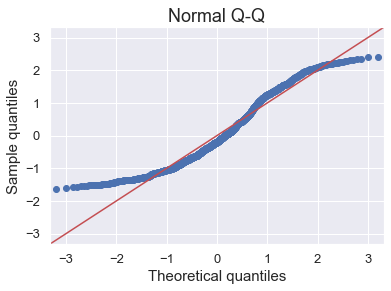

In [29]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(test_vs_pred["Residuals"],line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Normal Q-Q",fontsize=18)
plt.grid(True)
plt.show()